### Import

In [49]:
import numpy as np
import pandas as pd
import xarray as xr
from datetime import *
from functools import partial
import multiprocessing

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn.colors.xkcd_rgb as c
import cmaps
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [33]:
import vvmtoolsV2
import importlib
importlib.reload(vvmtools)

<module 'vvmtools' from '/data/mlcloud/ch995334/hw/vvmtools.py'>

## I. Define new class: VVM tools

**IDEAs**
- [X] Add new function: deal with grid positions and averaging (need to be expanded later for all variables)
- [X] Add new function: calculate $\overline{w'\theta'}$

### I. Testing section

In [68]:
myTools_test = myVVMTools("/data/mlcloud/ch995334/VVM/DATA/pbl_mod_wfire_coastal_s1/")

In [12]:
myTools_test.get_var(var="w", time=100, domain_range=(None, None, 0, 1, 0, 1))

<xarray.DataArray 'w' (lev: 50, lat: 1, lon: 1)>
array([[[ 0.      ]],

       [[-0.056016]],

       [[-0.058244]],

       [[-0.039588]],

       [[-0.020716]],

       [[-0.01009 ]],

       [[-0.006191]],

       [[-0.003981]],

       [[-0.002393]],

       [[-0.001256]],

       [[-0.001217]],

       [[-0.002375]],

       [[-0.003826]],

       [[-0.004801]],

       [[-0.005183]],

       [[-0.005158]],

       [[-0.004982]],

       [[-0.004877]],

       [[-0.004887]],

       [[-0.004939]],

       [[-0.004984]],

       [[-0.005052]],

       [[-0.005103]],

       [[-0.005076]],

       [[-0.005015]],

       [[-0.004944]],

       [[-0.004877]],

       [[-0.004837]],

       [[-0.004817]],

       [[-0.004811]],

       [[-0.004842]],

       [[-0.004872]],

       [[-0.004843]],

       [[-0.004795]],

       [[-0.004719]],

       [[-0.004582]],

       [[-0.004457]],

       [[-0.004344]],

       [[-0.004149]],

       [[-0.003857]],

       [[-0.003494]],

       [[-0.003044]],

       [[-0.002546]],

       [[-0.002059]],

       [[-0.001581]],

       [[-0.001178]],

       [[-0.000903]],

       [[-0.000671]],

       [[-0.000364]],

       [[ 0.      ]]], dtype=float32)
Coordinates:
    time     datetime64[ns] 1900-01-01T03:20:00
  * lev      (lev) float64 0.0 0.02 0.06 0.1 0.14 ... 1.78 1.82 1.86 1.9 1.94
  * lat      (lat) float64 -0.1142
  * lon      (lon) float64 -0.1142
Attributes:
    standard_name:  vertical_velocity
    long_name:      vertical velocity
    units:          m s-1

In [14]:
myTools_test.DIM

{'xc': array([  100.,   300.,   500.,   700.,   900.,  1100.,  1300.,  1500.,
         1700.,  1900.,  2100.,  2300.,  2500.,  2700.,  2900.,  3100.,
         3300.,  3500.,  3700.,  3900.,  4100.,  4300.,  4500.,  4700.,
         4900.,  5100.,  5300.,  5500.,  5700.,  5900.,  6100.,  6300.,
         6500.,  6700.,  6900.,  7100.,  7300.,  7500.,  7700.,  7900.,
         8100.,  8300.,  8500.,  8700.,  8900.,  9100.,  9300.,  9500.,
         9700.,  9900., 10100., 10300., 10500., 10700., 10900., 11100.,
        11300., 11500., 11700., 11900., 12100., 12300., 12500., 12700.,
        12900., 13100., 13300., 13500., 13700., 13900., 14100., 14300.,
        14500., 14700., 14900., 15100., 15300., 15500., 15700., 15900.,
        16100., 16300., 16500., 16700., 16900., 17100., 17300., 17500.,
        17700., 17900., 18100., 18300., 18500., 18700., 18900., 19100.,
        19300., 19500., 19700., 19900., 20100., 20300., 20500., 20700.,
        20900., 21100., 21300., 21500., 21700., 21900., 22

In [43]:
myTools_test.average_to_midgrid(var="w", time=100).shape

(49, 128, 128)

In [69]:
myTools_test.cal_vertical_theta_flux(time=100, domain_range=(None, None, None, 64, None, None)).shape

DEFAULT message: Using numpy for variable: w
theta shape: (49, 64, 128)


(49,)

### I. Building section

In [4]:
VVMTools_aaron = vvmtools.VVMTools

In [5]:
class myVVMTools(VVMTools_aaron):
    def __init__(self, case_path):
        super().__init__(case_path)
    
    def average_to_midgrid(self, 
                           var, 
                           time, 
                           domain_range=(None, None, None, None, None, None), # (k1, k2, j1, j2, i1, i2)
                           numpy=False, 
                           compute_mean=False, 
                           axis=None):
        if var != 'w':
            print("WARNING: Average for the assigned variable is currently inavailable.")
        else:
            org_var = self.get_var(var, time, domain_range, numpy=True, compute_mean=False, axis=False)
            #print(f"DEFAULT message: Using numpy for variable: {var}")
            return (org_var[:-1, ...]+org_var[1:, ...])/2.
        
    def cal_vertical_theta_flux(self, 
                                time, 
                                domain_range=(None, None, None, None, None, None), # (k1, k2, j1, j2, i1, i2)
                               ):
        w_midgrid   = self.average_to_midgrid(var='w', time=time, domain_range=domain_range, numpy=True)
        theta       = self.get_var(var='th', time=time, domain_range=domain_range, numpy=True)[1:, ...]   # omit z=0 (1st layer)
        #print("theta shape:", theta.shape)
        w_theta_bar = np.nanmean(w_midgrid*theta, axis=(-2, -1))
        w_bar       = np.nanmean(w_midgrid, axis=(-2, -1))
        theta_bar   = np.nanmean(theta, axis=(-2, -1))
        return w_theta_bar-(w_bar*theta_bar)
    
    def cal_pblH_wth_flux0(self, 
                           time,
                           domain_range=(None, None, None, None, None, None), # (k1, k2, j1, j2, i1, i2), 
                           print_info=True):
        zc                 = self.DIM['zc'][1:]
        wth_flux_at_time   = self.cal_vertical_theta_flux(time, domain_range)               # height equivalent to zc[1:]
        sign_change_indices= (np.arange(zc.shape[0]-1))[wth_flux_at_time[:-1]*wth_flux_at_time[1:]<=0]  # apply to zc[1:]
        if sign_change_indices.shape[0]<1:
            sign_change_heights = np.array([np.nan])
            neg_height_in_h1h2  = np.nan
        elif (sign_change_indices.shape[0]>0)&(sign_change_indices.shape[0]<2):
            sign_change_heights= (zc[sign_change_indices]+zc[sign_change_indices+1])/2
            neg_height_in_h1h2  = np.nan
        else:
            sign_change_heights= (zc[sign_change_indices]+zc[sign_change_indices+1])/2
            neg_idx_in_h1h2    = np.argmin(wth_flux_at_time[sign_change_indices[0]:sign_change_indices[1]+1])
            neg_height_in_h1h2 = (zc[sign_change_indices[0]+neg_idx_in_h1h2]+zc[sign_change_indices[0]+neg_idx_in_h1h2+1])/2
        # --- Print returned info. --- #
        if print_info:
            print(f"Return 1: Array of sign-change indices.")
            print(f"Return 2: Averaged-height where the sign of w'th' changes.")
            print(f"Return 3: Averaged height of most negative w'th' between 1st and 2nd sign-change height.")
        return sign_change_indices, sign_change_heights, neg_height_in_h1h2

### (Shared) Objects

In [27]:
# Emission at coast
casename_cs1 = 'pbl_mod_wfire_coastal_s1'
casename_cs2 = 'pbl_mod_wfire_coastal_s2'
# Emission at inland
casename_is1 = 'pbl_mod_wfire_inland_s1'
casename_is2 = 'pbl_mod_wfire_inland_s2'

In [7]:
myTools_cs1  = myVVMTools(f"/data/mlcloud/ch995334/VVM/DATA/{casename_cs1}")
myTools_cs2  = myVVMTools(f"/data/mlcloud/ch995334/VVM/DATA/{casename_cs2}")
myTools_is1  = myVVMTools(f"/data/mlcloud/ch995334/VVM/DATA/{casename_is1}")
myTools_is2  = myVVMTools(f"/data/mlcloud/ch995334/VVM/DATA/{casename_is2}")

In [8]:
ocean_domain  = (None, None, None, 64, None, None)
forest_domain = (None, None, 64, None, None, None)

In [9]:
zc = myTools_cs1.DIM['zc']

## II. Vertical theta flux

### II. Testing section

In [80]:
wth_flux_cs1_ocn = myTools_cs1.cal_vertical_theta_flux(time=10, domain_range=ocean_domain)

DEFAULT message: Using numpy for variable: w
theta shape: (49, 64, 128)


In [145]:
test = myTools_cs1.cal_pblH_wth_flux0(time=150, domain_range=ocean_domain)

DEFAULT message: Using numpy for variable: w
theta shape: (49, 64, 128)
Return 1: Array of sign-change indices.
Return 2: Averaged-height where the sign of w'th' changes.
Return 3: Averaged height of most negative w'th' between 1st and 2nd sign-change height.


In [146]:
test

(array([ 9, 18, 43, 47]), array([ 400.,  760., 1760., 1920.]), 520.0)

### II. Execution Section

In [207]:
def Plot_wth_flux_dmean(time:int, case:str, figpath=False):
    myTools_Case = eval(f'myTools_{case}')
    ocn_test = myTools_Case.cal_vertical_theta_flux(time=time, 
                                                   domain_range=ocean_domain)
    frst_test= myTools_Case.cal_vertical_theta_flux(time=time, 
                                                   domain_range=forest_domain)
    ocn_th   = np.nanmean(myTools_Case.get_var(var='th', time=time, domain_range=ocean_domain), axis=(-1, -2))[1:, ...]
    frst_th  = np.nanmean(myTools_Case.get_var(var='th', time=time, domain_range=forest_domain), axis=(-1, -2))[1:, ...]
    fig, ax  = plt.subplots(1, 2, figsize=(10, 6))
    # w'theta'
    ax[0].grid()
    ax[0].plot(ocn_test, zc[1:], 'b-', linewidth=3, label='Ocean')
    ax[0].plot(frst_test, zc[1:], 'g-', linewidth=3, label='Forest')
    ax[0].legend(fontsize=12)
    ax[0].set_xlim(-4e-2, 4e-2)
    ax[0].set_xticks(np.arange(-4e-2, 4.1e-2, 2e-2))
    #ax[0].set_xlabel(r'$\overline{w'\theta'}$')
    ax[0].set_title(f'{(datetime(2024, 1, 1, 5)+timedelta(seconds=120*tt)).strftime("%H:%M:%S")}',
              loc='left', fontsize=12)
    ax[0].set_title(f'wth flux', fontsize=12)
    # theta
    ax[1].grid()
    ax[1].plot(ocn_th, zc[1:], 'b-', linewidth=3, label='Ocean')
    ax[1].plot(frst_th, zc[1:], 'g-', linewidth=3, label='Forest')
    ax[1].legend(fontsize=12)
    ax[1].set_xlim(290, 310)
    ax[1].set_xticks(np.arange(290, 310.1, 10))
    #ax[1].set_xlabel(r'$\overline{w'\theta'}$')
    ax[1].set_title(r'$\theta$', fontsize=12)
    if figpath:
        plt.savefig(f'/data/mlcloud/ch995334/hw/Figure/{figpath}/ts_{time:03d}.png', bbox_inches='tight',
                    facecolor='w', dpi=400)
    else:
        plt.show()

In [ ]:
for tt in range(721):
    Plot_wth_flux_dmean(time=tt, case='cs1', figpath='hw6_wth_prof_cs1')

In [ ]:
for tt in range(721):
    Plot_wth_flux_dmean(time=tt, case='cs2', figpath='hw6_wth_prof_cs2')

In [ ]:
!ffmpeg -r 10 -f image2 -y -pattern_type glob -i './Figure/hw6_wth_prof_cs2/*.png' -q:v 1 -vcodec libx264 -crf 25 -pix_fmt yuv420p -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" ./Figure/hw6_wth_prof_cs2/hw6_wth_prof_cs2.mp4

#### Get PBL height using w'th'

In [204]:
def get_pblh_wth_landtype(case:str, savefile=False):
    ocn_pblh_wth  = {'pblH_1st0':[], 'pblH_negmax':[]}
    frst_pblh_wth = {'pblH_1st0':[], 'pblH_negmax':[]}
    # VVM tools
    myTools_Case  = eval(f'myTools_{case}')
    # Calculate different PBL height
    for tt in range(721):
        ocn_returns     = myTools_Case.cal_pblH_wth_flux0(time=tt, domain_range=ocean_domain, print_info=False)
        frst_returns    = myTools_Case.cal_pblH_wth_flux0(time=tt, domain_range=forest_domain, print_info=False)

        try:
            ocn_pblh_wth['pblH_1st0'].append(ocn_returns[1][0])
            ocn_pblh_wth['pblH_negmax'].append(ocn_returns[2])
            frst_pblh_wth['pblH_1st0'].append(frst_returns[1][0])
            frst_pblh_wth['pblH_negmax'].append(frst_returns[2])
        except:
            ocn_pblh_wth['pblH_1st0'].append(np.nan)
            ocn_pblh_wth['pblH_negmax'].append(np.nan)
            frst_pblh_wth['pblH_1st0'].append(np.nan)
            frst_pblh_wth['pblH_negmax'].append(np.nan)
        if tt%50 <1: print(tt)   # iteration record
    # Save file
    if savefile:
        np.save(f'/data/mlcloud/ch995334/hw/Data/hw6_ocn_pblh_wth_{case}.npy', ocn_pblh_wth)
        np.save(f'/data/mlcloud/ch995334/hw/Data/hw6_frst_pblh_wth_{case}.npy', frst_pblh_wth)

In [206]:
get_pblh_wth_landtype(case='cs1', savefile=True)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700


### Test

In [10]:
qc_cs2 = myTools_cs2.get_var_parallel(var='qc', time_steps=np.arange(0, 391))

In [11]:
qi_cs2 = myTools_cs2.get_var_parallel(var='qi', time_steps=np.arange(0, 391))

In [12]:
qr_cs2 = myTools_cs2.get_var_parallel(var='qr', time_steps=np.arange(0, 391))

In [13]:
qci_cs2= qc_cs2+qi_cs2

In [14]:
qci_sum= np.sum(qci_cs2, axis=(-2, -1))

In [15]:
qr_sum = np.sum(qr_cs2, axis=(-2, -1))

Text(0.5, 1.0, '$Q_{c}$ + $Q_{i}$ Domain Sum')

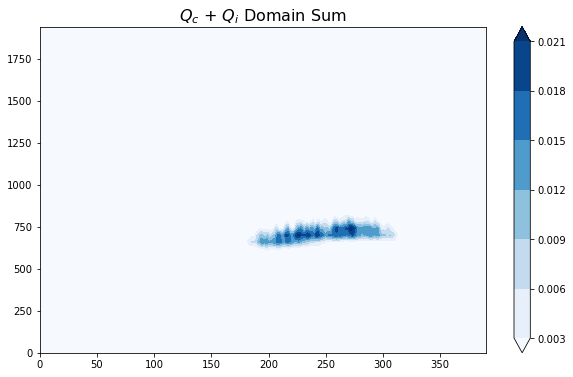

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
imsum   = ax.contourf(np.arange(391), zc, qci_sum.T, 
                      cmap=cmaps.MPL_Blues, extend='both')
fig.colorbar(imsum)
ax.set_title(r'$Q_{c}$ + $Q_{i}$ Domain Sum', fontsize=16)

Text(0, 0.5, 'Height (m)')

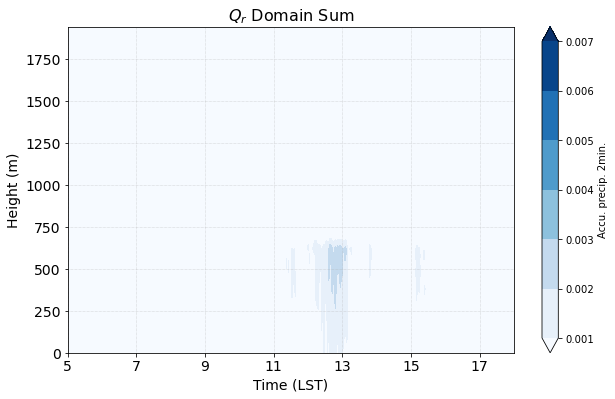

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(linestyle=':', linewidth=0.5)
imsum   = ax.contourf(np.arange(391), zc, (qr_sum.T)*120, levels=np.arange(1e-3, 8e-3, 1e-3),
                      cmap=cmaps.MPL_Blues, extend='both')
fig.colorbar(imsum, label='Accu. precip. 2min.')
ax.set_xticks(np.arange(0, 391, 60))
ax.set_xticklabels(np.arange(5, 18.1, 2).astype(int), fontsize=14)
ax.set_yticks(np.arange(0, zc[-1], 250))
ax.set_yticklabels(np.arange(0, zc[-1], 250).astype(int), fontsize=14)
ax.set_title(r'$Q_{r}$ Domain Sum', fontsize=16)
ax.set_xlabel('Time (LST)', fontsize=14)
ax.set_ylabel('Height (m)', fontsize=14)

Text(0, 0.5, 'Height (m)')

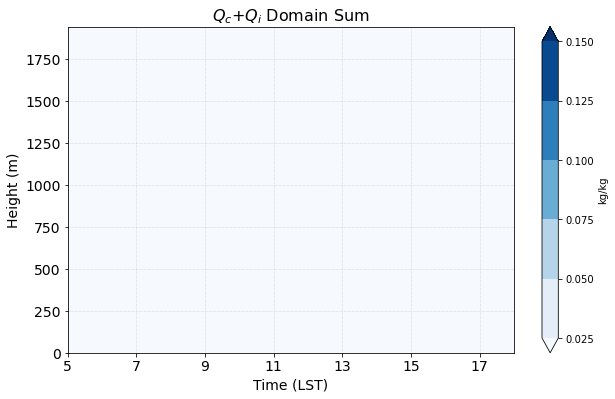

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(linestyle=':', linewidth=0.5)
imsum   = ax.contourf(np.arange(391), zc, (qci_sum.T), levels=np.arange(0.025, 0.151, 0.025), 
                      cmap=cmaps.MPL_Blues, extend='both')
fig.colorbar(imsum, label='kg/kg')
ax.set_xticks(np.arange(0, 391, 60))
ax.set_xticklabels(np.arange(5, 18.1, 2).astype(int), fontsize=14)
ax.set_yticks(np.arange(0, zc[-1], 250))
ax.set_yticklabels(np.arange(0, zc[-1], 250).astype(int), fontsize=14)
ax.set_title(r'$Q_{c}$+$Q_{i}$ Domain Sum', fontsize=16)
ax.set_xlabel('Time (LST)', fontsize=14)
ax.set_ylabel('Height (m)', fontsize=14)

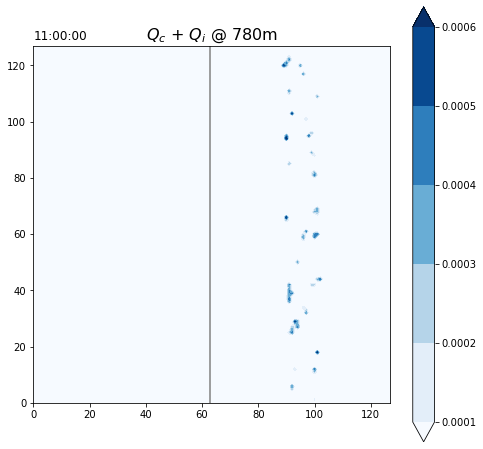

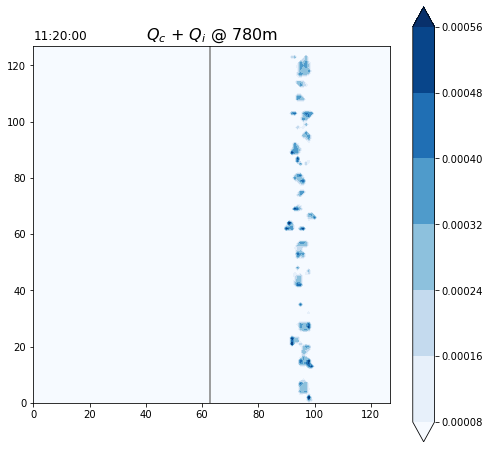

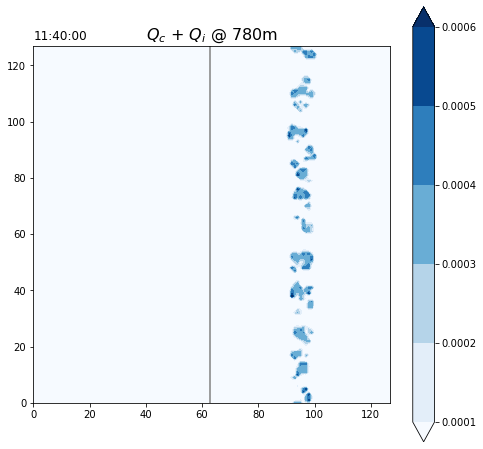

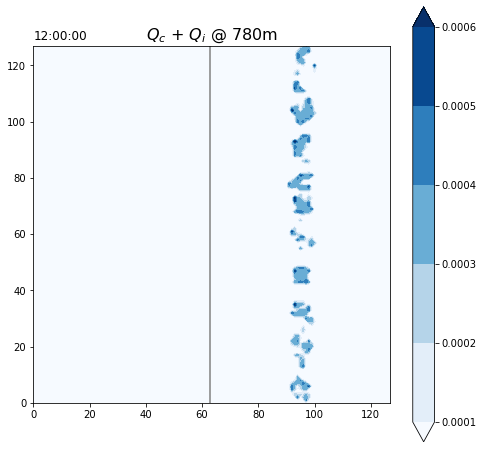

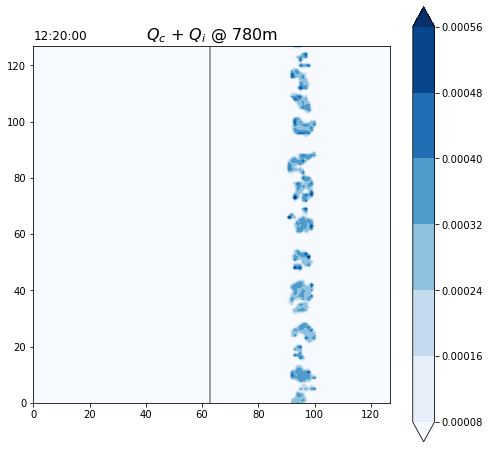

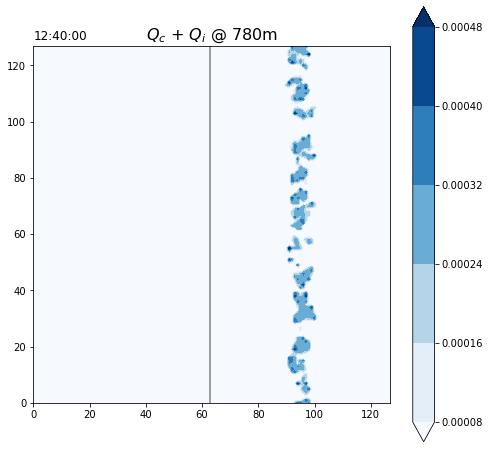

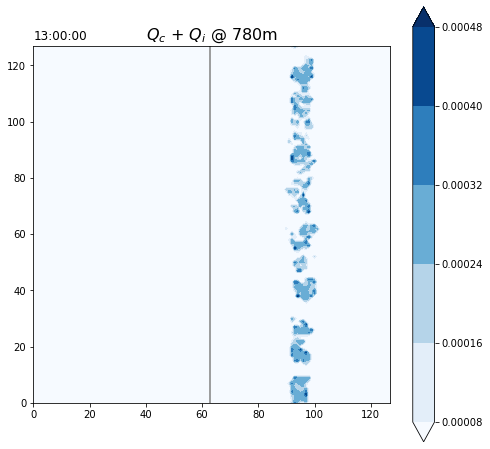

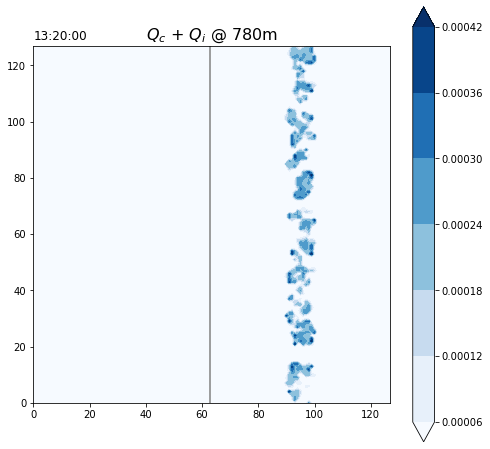

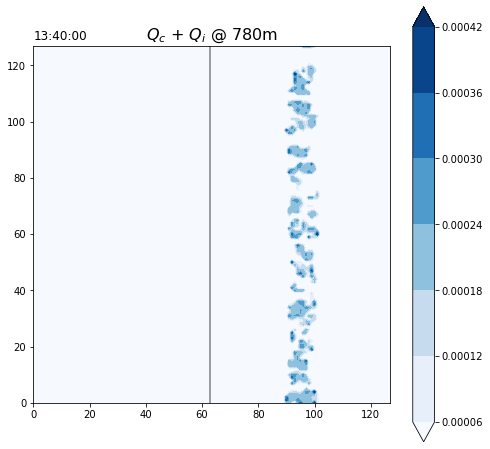

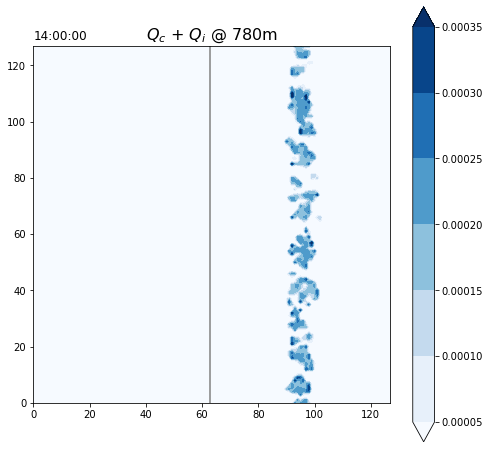

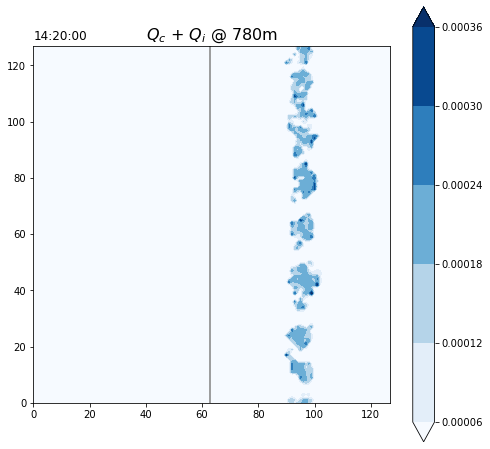

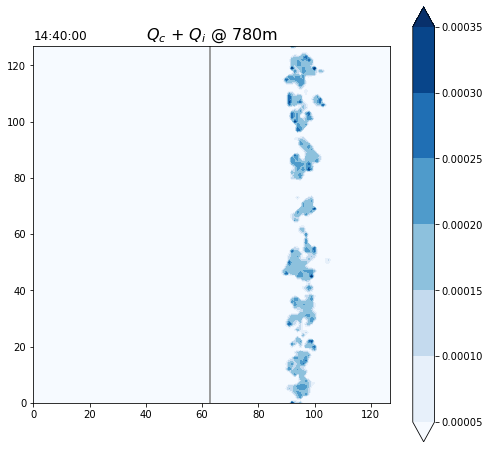

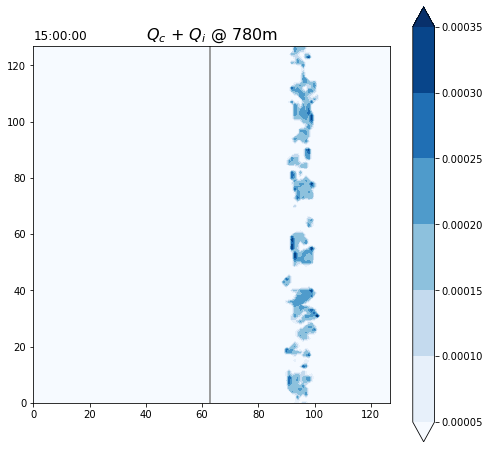

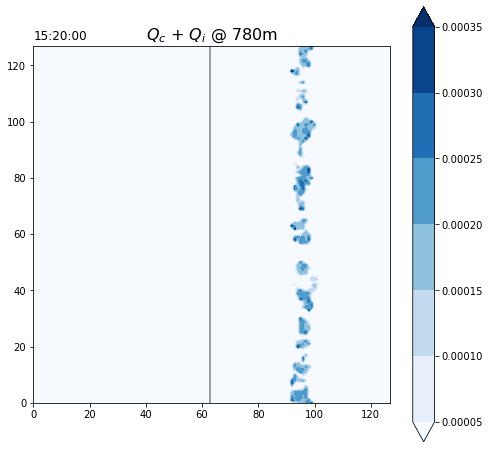

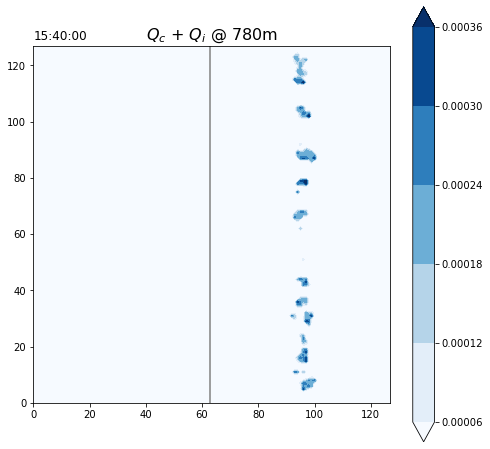

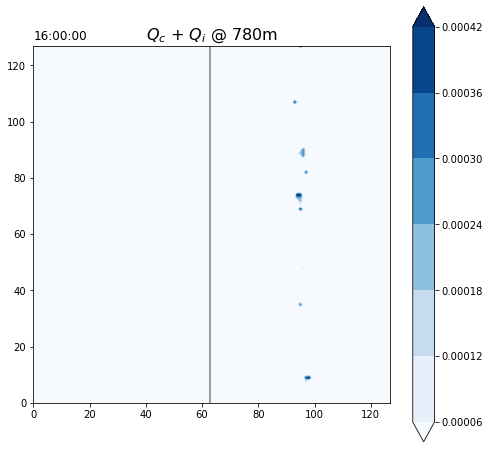

In [263]:
for tt in range(180, 331, 10):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal', 'box')
    imcloud = ax.contourf(np.arange(128), np.arange(128), np.squeeze(qci_cs1[tt, zc==780, ...]), cmap=cmaps.MPL_Blues, extend='both')
    fig.colorbar(imcloud)
    ax.vlines(x=63, ymin=0, ymax=127, color='grey')
    ax.set_title(r'$Q_{c}$ + $Q_{i}$ @ 780m', fontsize=16)
    ax.set_title(f'{(datetime(2024, 1, 1, 5)+timedelta(seconds=120*tt)).strftime("%H:%M:%S")}', 
                 loc='left', fontsize=12)

In [236]:
qci_cs1[0, zc==780, ...].shape

(1, 128, 128)

In [ ]:
for tt in range(180, 331, 10):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal', 'box')
    imcloud = ax.contourf(np.arange(128), np.arange(128), np.squeeze(qci_cs2[tt, zc==780, ...]), cmap=cmaps.MPL_Blues, extend='both')
    fig.colorbar(imcloud)
    ax.vlines(x=63, ymin=0, ymax=127, color='grey')
    ax.set_title(r'$Q_{c}$ + $Q_{i}$ @ 780m', fontsize=16)
    ax.set_title(f'{(datetime(2024, 1, 1, 5)+timedelta(seconds=120*tt)).strftime("%H:%M:%S")}', 
                 loc='left', fontsize=12)

## Test vvmtoolsV2

In [63]:
toolsV2_cs1 = vvmtoolsV2.VVMtools(f"/data/mlcloud/ch995334/VVM/DATA/{casename_cs1}")

In [67]:
no_test = toolsV2_cs1.get_var('NO', time=1)

In [68]:
no_test.max()

<xarray.DataArray 'NO' ()>
array(1555.23999023)

In [35]:
toolsV2_cs1.get_pbl_height(180, (None, None, None, None, 64, None), 
                           method='th05k', compute_mean_axis='xy')

500.0

In [36]:
func_config={'domain_range':(None, None, None, None, 64, None), 
             'method':'th05k', 
             'compute_mean_axis':'xy'}
toolsV2_cs1.func_time_parallel(func=toolsV2_cs1.get_pbl_height, time_steps=np.arange(20), func_config=func_config)

TypeError: func_time_parallel() got an unexpected keyword argument 'func_config'

In [46]:
class V2test(vvmtoolsV2.VVMtools):
    def __init__(self, casepath):
        super().__init__(casepath)
        
    def func_time_parallel(self, 
                           func, 
                           time_steps=None, # Signature shows np.arange(0, 720, 1)
                           func_config=None,
                           cores=5):
        # If time_steps is None, use np.arange(0, 720, 1)
        if time_steps is None:
            time_steps = np.arange(0, 720, 1)
        
        if type(time_steps) == np.ndarray:
            time_steps = time_steps.tolist()
            
        if not isinstance(time_steps, (list, tuple)):
            raise TypeError("time_steps must be a list or tuple of integers.")

        # Create a partial function that pre-binds the config to the func
        func_with_config = partial(func, **func_config)

        # Use multiprocessing to fetch variable data in parallel
        with multiprocessing.Pool(processes=cores) as pool:
            results = pool.starmap(func_with_config, [(time, ) for time in time_steps])
        
        # Combine and return the results
        return np.squeeze(np.array(results))

In [47]:
V2test_cs1 = V2test(f"/data/mlcloud/ch995334/VVM/DATA/{casename_cs1}")

In [51]:
V2test_cs1.func_time_parallel(func=V2test_cs1.get_pbl_height, time_steps=np.arange(180, 350), func_config=func_config)

array([500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500., 500., 500., 540., 540., 540., 540., 540., 540., 540., 540.,
       540., 540., 540., 580., 580., 580., 580., 580., 580., 580., 580.,
       580., 580., 580., 580., 580., 580., 620., 620., 620., 620., 620.,
       620., 620., 620., 620., 620., 620., 620., 620., 620., 620., 620.,
       620., 620., 620., 620., 620., 660., 660., 660., 660., 660., 660.,
       660., 660., 660., 660., 660., 660., 660., 660., 660., 660., 660.,
       660., 660., 660., 660., 660., 660., 660., 660., 660., 660., 660.,
       660., 660., 660., 660., 660., 660., 660., 660., 660., 660., 660.,
       660., 660., 660., 660., 660., 660., 660., 660., 660., 660., 660.,
       660., 660., 660., 660., 660., 660., 620., 620., 620., 620., 620.,
       620., 620., 620., 620., 620., 620., 620., 620., 620., 620., 620.,
       620., 580., 580., 580., 580., 580., 580., 58

In [62]:
a = np.array([np.nan, 1])
b = np.array([2, 1])
c = np.array([np.nan, np.nan])
~np.all(np.isnan(a))
# np.nanmin(c)

True